In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import enzope

In [4]:
def mean_exchange(r1, wi, rj, wj):
    return (wi + wj) / 2
def constant_exchange(r1, wi, rj, wj):
    return .0001

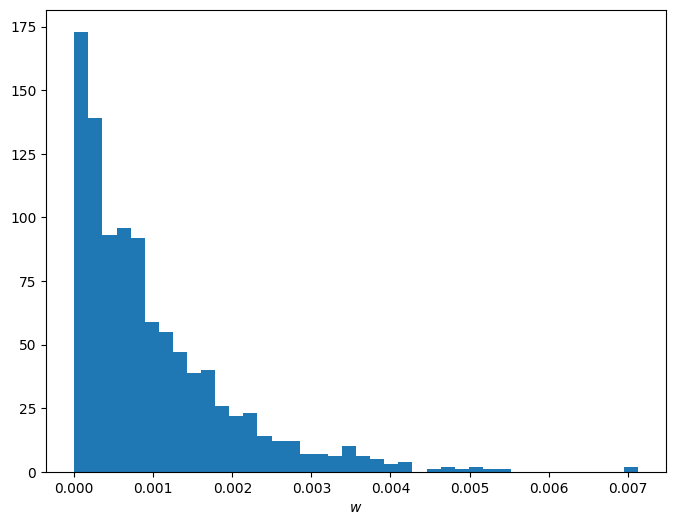

In [3]:
model = enzope.CPUModel(n_agents=1000, interaction=mean_exchange)
model.MCS(5000)
fig = enzope.distribution(model.w, bins=40)

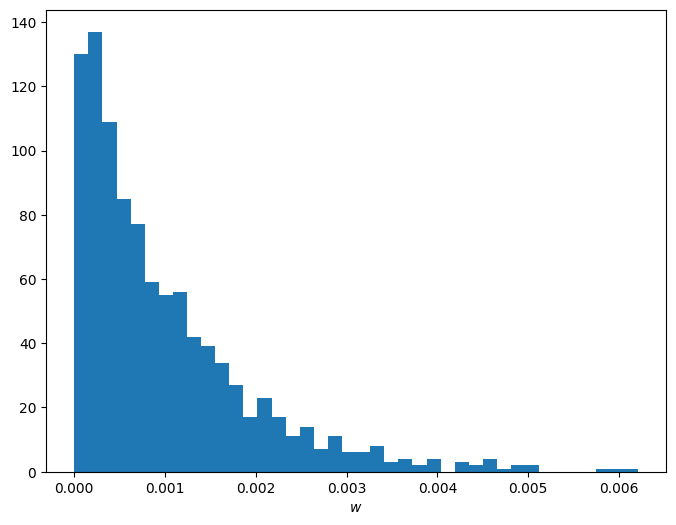

In [5]:
model = enzope.CPUModel(n_agents=1000, interaction=constant_exchange)
model.MCS(5000)
fig = enzope.distribution(model.w, bins=40)

In [5]:
def run_simulation(mcs=1000, r_frac=.7, f=.1, reps=10):
    gini1 = []
    gini2 = []
    for rep in tqdm(range(reps)):
        model1 = enzope.CPUModel(n_agents=500, f=f, measure_every=1)
        model2 = enzope.CPUModel(n_agents=500, f=f, measure_every=1)
        model2.r = np.random.uniform(0, r_frac, size=model2.n_agents)
        model1.MCS(mcs)
        model2.MCS(mcs)
        gini1.append(model1.gini)
        gini2.append(model2.gini)

    mean_1 = np.mean(gini1, axis=0)
    mean_2 = np.mean(gini2, axis=0)
    std_1 = np.std(gini1, axis=0)
    std_2 = np.std(gini2, axis=0)

    return mean_1, mean_2, std_1, std_2
    

In [6]:
r_max=.7
gini1, gini2, std1, std2 = run_simulation(mcs=200000, r_frac=r_max, f=.1, reps=15)

100%|██████████| 15/15 [3:56:48<00:00, 947.20s/it]  


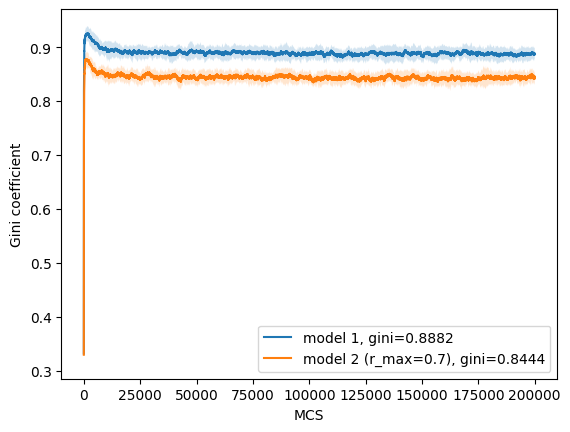

In [7]:
# plot model ginis
fig, ax = plt.subplots()
ax.plot(gini1, label=f'model 1, gini={np.mean(gini1[-1000:]):.4f}')
ax.fill_between(range(len(gini1)), gini1-std1, gini1+std1, alpha=.2)
ax.plot(gini2, label=f'model 2 (r_max={r_max}), gini={np.mean(gini2[-1000:]):.4f}')
ax.fill_between(range(len(gini2)), gini2-std2, gini2+std2, alpha=.2)
ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel('Gini coefficient');
# fig.savefig('figs/gini.png', dpi=300)

### Simulation loop

In [3]:
def run_simulation2(mcs=1000, rs=None, f=.1):
    if rs is None:
        rs = [1]
    ginis = []
    actives = []
    liquidity = []
    wealths = []
    models = [enzope.CPUModel(n_agents=1000, f=f, measure_every=1) for r in rs]
    for model, r_max in zip(models, rs):
        model.r = np.random.uniform(0, r_max, size=model.n_agents)
        model.MCS(mcs)
        ginis.append(model.gini)
        actives.append(model.n_active)
        liquidity.append(model.liquidity)
        wealths.append(model.w)

    return ginis, actives, liquidity, wealths

In [4]:
def run_ensemble(f=.1, reps=10, mcs=1000):
    rs = [.2, .4, .6, .8, 1.0]
    mcs = mcs
    f = f
    reps = reps

    gini_ensemble = []
    actives_ensemble = []
    liquidity_ensemble = []
    wealths_ensemble = []
    for _ in tqdm(range(reps)):
        gini, actives, liquidity, wealths = run_simulation2(mcs=mcs, rs=rs, f=f)
        gini_ensemble.append(gini)
        actives_ensemble.append(actives)
        liquidity_ensemble.append(liquidity)
        wealths_ensemble.append(wealths)


    np.save(f'data/gini_ensemble_f={f}_mcs={mcs}_various_r_max.npy', gini_ensemble)
    np.save(f'data/actives_ensemble_f={f}_mcs={mcs}_various_r_max.npy', actives_ensemble)
    np.save(f'data/liquidity_ensemble_f={f}_mcs={mcs}_various_r_max.npy', liquidity_ensemble)
    np.save(f'data/wealths_ensemble_f={f}_mcs={mcs}_various_r_max.npy', wealths_ensemble)


    mean_ginis = np.mean(gini_ensemble, axis=0)
    std_ginis = np.std(gini_ensemble, axis=0)

    fig, ax = plt.subplots()
    for r, gini, std in zip(rs, mean_ginis, std_ginis):
        ax.plot(gini, label=r'$r_{m}$'+f'={r}, G={np.mean(gini[-100:]):.2f}')
        ax.fill_between(range(len(gini)), gini-std, gini+std, alpha=.2)
    ax.legend()
    ax.set_xlabel('MCS')
    ax.set_ylabel('Gini coefficient');
    ax.set_title(f'$f={f}$')
    plt.grid()
    fig.savefig(f'figs/ginis_f={f}.svg')
    fig.savefig(f'figs/ginis_f={f}.png', dpi=300)
    plt.show()


### Main

100%|██████████| 5/5 [52:30<00:00, 630.14s/it]


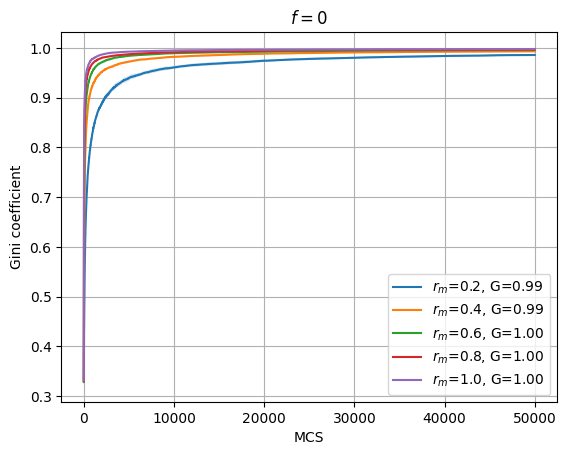

100%|██████████| 5/5 [2:16:21<00:00, 1636.23s/it]


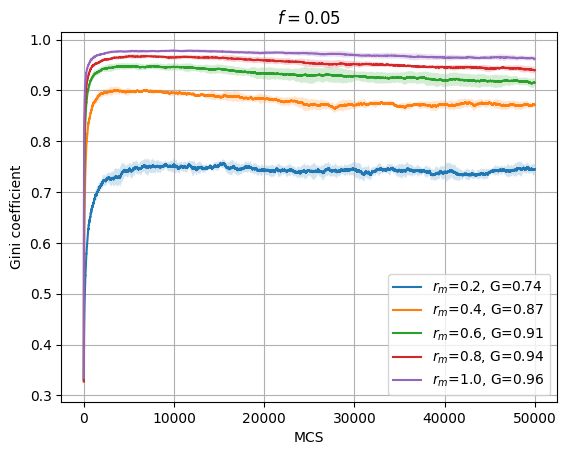

100%|██████████| 5/5 [3:37:59<00:00, 2615.98s/it]  


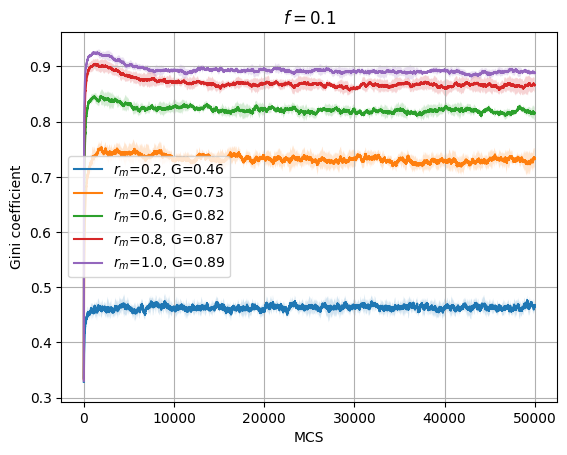

100%|██████████| 5/5 [5:35:32<00:00, 4026.51s/it]  


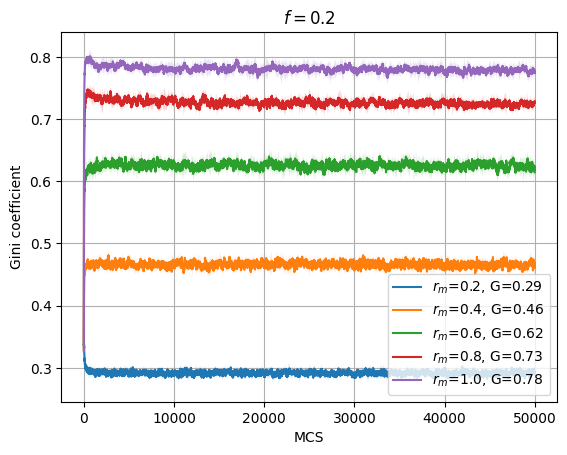

100%|██████████| 5/5 [6:26:35<00:00, 4639.18s/it]  


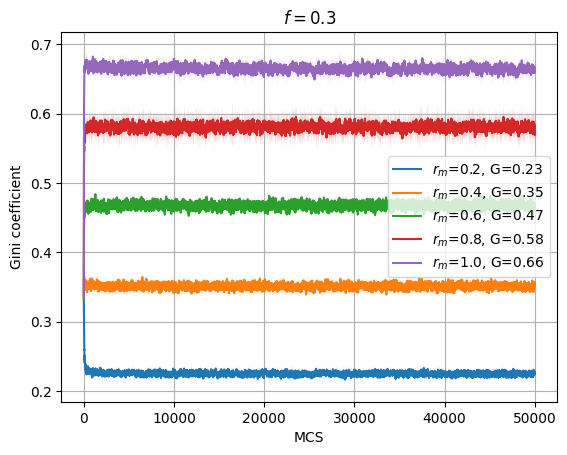

In [28]:
for f in [0, .05, .1, .2, .3]:
    run_ensemble(f=f, reps=5, mcs=50000)

## Ploteando

In [86]:
rs = [.2, .4, .6, .8, 1.0]
fs = [0, .05, .1, .2, .3]

### Gini final en funcion de r_max para varios f

In [81]:
gini_final = []

for f in fs:
    gini_ensemble = np.load(f'data/gini_ensemble_f={f}_mcs=50000_various_r_max.npy')
    aux = [np.mean(gini[-1000:], axis=1) for gini in gini_ensemble]
    gini_final.append(np.mean(aux, axis=0))


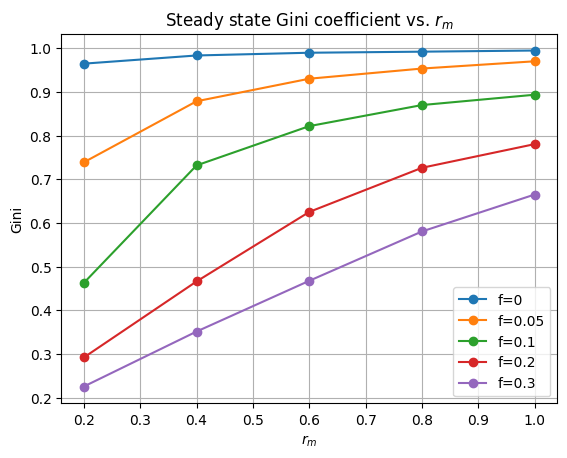

In [82]:
for f in fs:
    plt.plot(rs, gini_final[fs.index(f)], label=f'f={f}', marker='o')
plt.xlabel(r'$r_{m}$')
plt.ylabel('Gini')
plt.legend()
plt.title('Steady state Gini coefficient vs. $r_{m}$')
plt.grid()
# plt.savefig('figs/gini_vs_r_max.png', dpi=300)
plt.show()

### Agentes activos

In [91]:
actives_ensemble = np.load(f'data/actives_ensemble_f={f}_mcs=50000_various_r_max.npy')
actives_mean = np.mean(actives_ensemble, axis=0)
actives_std = np.std(actives_ensemble, axis=0)

In [95]:
actives_mean

array([[1.    , 1.    , 1.    , ..., 0.2534, 0.2534, 0.2534],
       [1.    , 1.    , 1.    , ..., 0.1674, 0.1674, 0.1674],
       [1.    , 1.    , 1.    , ..., 0.1266, 0.1266, 0.1266],
       [1.    , 1.    , 1.    , ..., 0.1054, 0.1054, 0.1054],
       [1.    , 1.    , 1.    , ..., 0.087 , 0.087 , 0.087 ]])

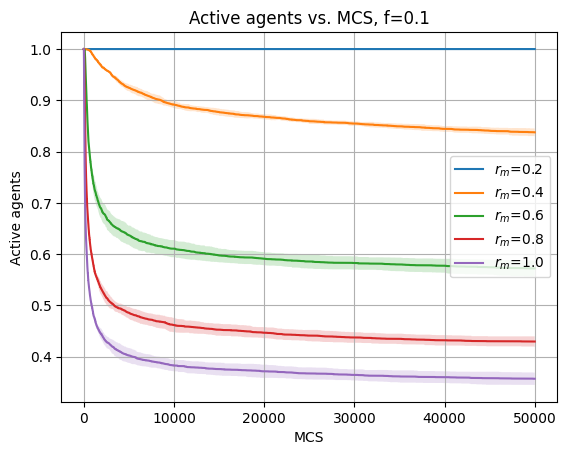

In [101]:
# Plot active agents as a function of time (not steady state) vs r_max, one plot for each f
actives_final = []

f = 0.1
actives_ensemble = np.load(f'data/actives_ensemble_f={f}_mcs=50000_various_r_max.npy')
actives_mean = np.mean(actives_ensemble, axis=0)
actives_std = np.std(actives_ensemble, axis=0)

for r, mean, std in zip(rs, actives_mean, actives_std):
    plt.plot(mean, label=r'$r_{m}$'+f'={r}')
    plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=.2)
plt.xlabel('MCS')
plt.ylabel('Active agents')
plt.legend()
plt.title(f'Active agents vs. MCS, f={f}')
plt.grid()


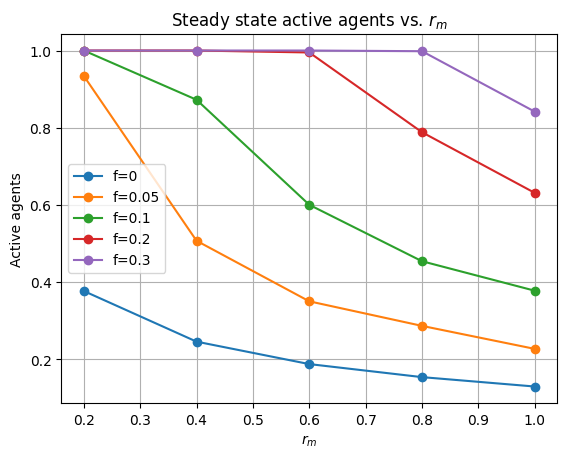

In [87]:
# Plot of the number of active agents vs. $r_{m}$ for different values of $f$
actives_final = []

for f in fs:
    actives_ensemble = np.load(f'data/actives_ensemble_f={f}_mcs=50000_various_r_max.npy')
    aux = [np.mean(actives[-1000:], axis=1) for actives in actives_ensemble]
    actives_final.append(np.mean(aux, axis=0))


for f in fs:
    plt.plot(rs, actives_final[fs.index(f)], label=f'f={f}', marker='o')
plt.xlabel(r'$r_{m}$')
plt.ylabel('Active agents')
plt.legend()
plt.title('Steady state active agents vs. $r_{m}$')
plt.grid()
# plt.savefig('figs/actives_vs_r_max.png', dpi=300)
plt.show()

### Ideas para plotear

In [19]:
actives = np.load('data/actives_ensemble_f=0_mcs=50_various_r_max.npy')
actives.shape

(2, 5, 50)

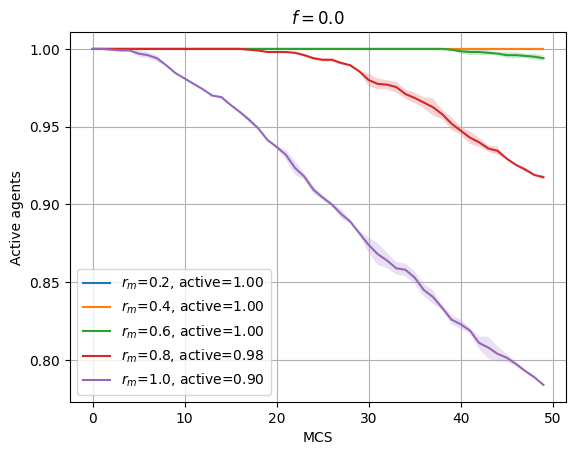

In [20]:
mean_active = np.mean(actives, axis=0)
std_active = np.std(actives, axis=0)

f=0.
rs=[.2, .4, .6, .8, 1.0]

fig, ax = plt.subplots()
for r, actives, std in zip(rs, mean_active, std_active):
    ax.plot(actives, label=r'$r_{m}$'+f'={r}, active={np.mean(actives[-100:]):.2f}')
    ax.fill_between(range(len(actives)), actives-std, actives+std, alpha=.2)

ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel('Active agents');
ax.set_title(f'$f={f}$')
plt.grid()
plt.show()



In [21]:
liquidity = np.load('data/liquidity_ensemble_f=0_mcs=50_various_r_max.npy')
liquidity.shape

mean_liquidity = np.mean(liquidity, axis=0)
std_liquidity = np.std(liquidity, axis=0)

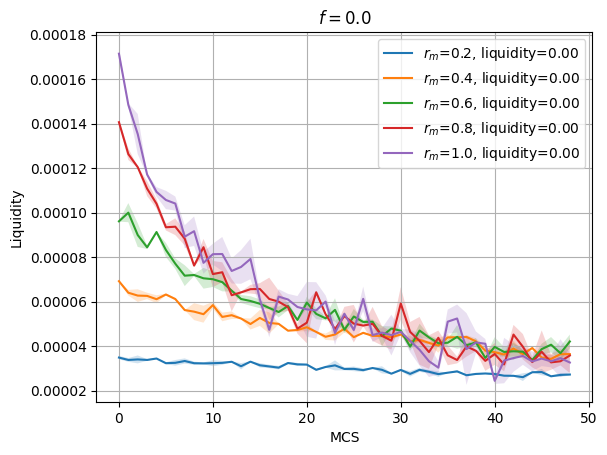

In [22]:
fig, ax = plt.subplots()
for r, liquidity, std in zip(rs, mean_liquidity, std_liquidity):
    ax.plot(liquidity, label=r'$r_{m}$'+f'={r}, liquidity={np.mean(liquidity[-100:]):.2f}')
    ax.fill_between(range(len(liquidity)), liquidity-std, liquidity+std, alpha=.2)

ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel('Liquidity');
ax.set_title(f'$f={f}$')
plt.grid()
plt.show()


In [23]:
wealths = np.load('data/wealths_ensemble_f=0_mcs=50_various_r_max.npy')
wealths.shape

(2, 5, 1000)

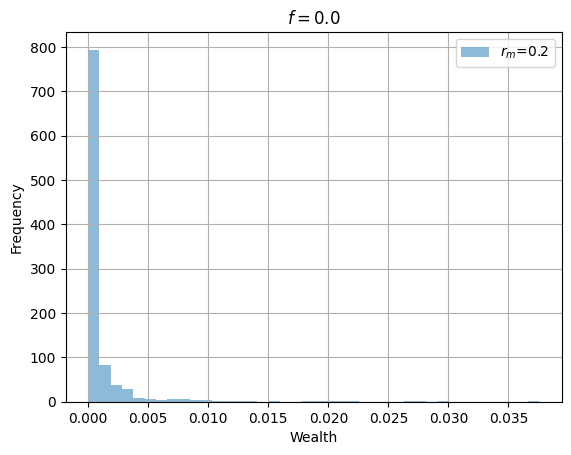

In [27]:
# Now plot a histogram of the wealths, where each rep is included, and I want a histogram for every r_max
fig, ax = plt.subplots()
ax.hist(wealths[1, 4], bins=40, alpha=.5, label=r'$r_{m}$'+f'={rs[0]}')
ax.legend()
ax.set_xlabel('Wealth')
ax.set_ylabel('Frequency')
ax.set_title(f'$f={f}$')
plt.grid()
plt.show()
